##Cats vs Dogs full

In [1]:
# key file upload
from google.colab import files
up = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
import os, json

with open('kaggle.json') as f:
    kaggle = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle['username']
os.environ['KAGGLE_KEY'] = kaggle['key']

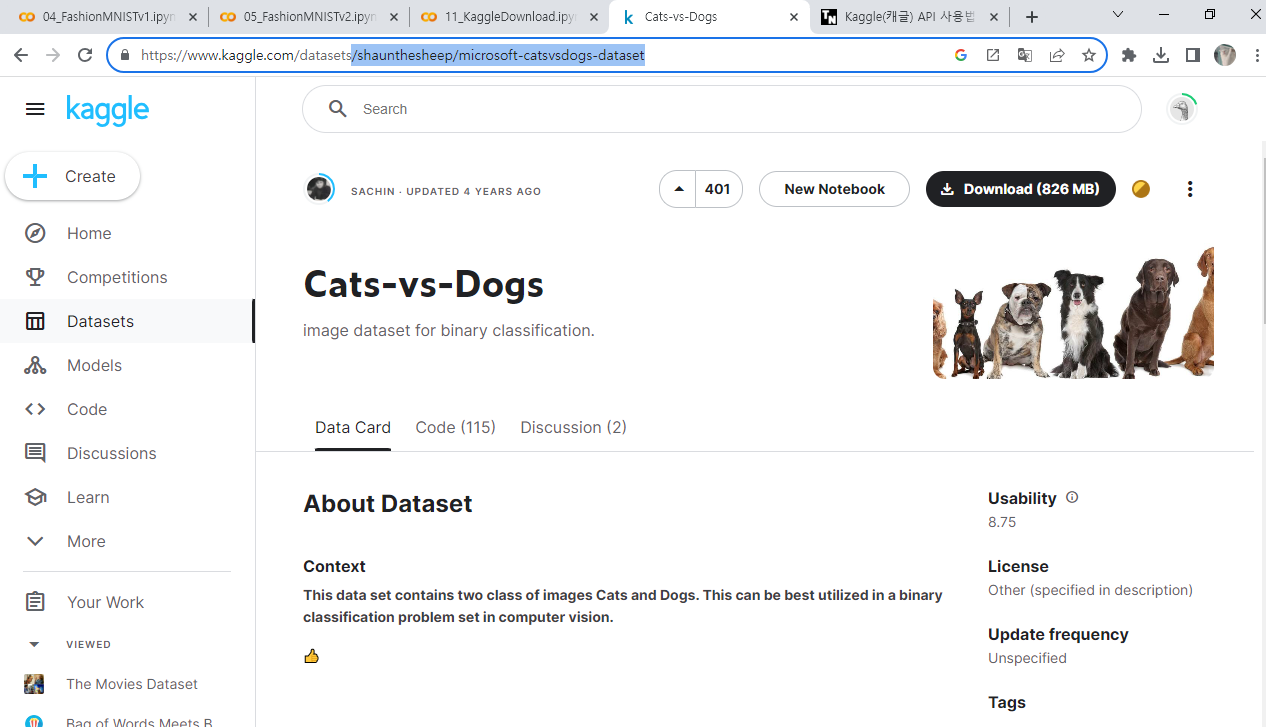

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

100% 784M/788M [00:05<00:00, 70.8MB/s]
100% 788M/788M [00:05<00:00, 138MB/s] 


In [4]:
!unzip microsoft-catsvsdogs-dataset.zip > filenames
  # 압축해제 후 파일 네임만 확인해보는 코드
  # 내가 다운받은 데이터셋 파일은 PetImages폴더 안에 있음

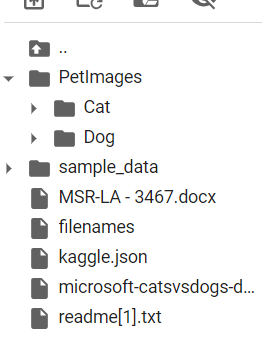

In [5]:
cat_dir = 'PetImages/Cat'
os.unlink(f'{cat_dir}/Thumbs.db')     # 압축 해제시 생성된 임시파일 삭제
cat_list = os.listdir(cat_dir)
len(cat_list)

12500

In [6]:
dog_dir = 'PetImages/Dog'
os.unlink(f'{dog_dir}/Thumbs.db')     # 압축 해제시 생성된 임시파일 삭제
dog_list = os.listdir(dog_dir)
len(dog_list)

12500

- 이미지 파일 에러 찾기

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from PIL import Image
from glob import glob

In [9]:
cat_list[:5]

['11867.jpg', '9234.jpg', '2025.jpg', '11224.jpg', '7258.jpg']

In [10]:
# 어떤 파일에서 에러가 나는지 확인
for fname in cat_list:
  try:
    img = Image.open(f'PetImages/Cat/{fname}')
  except:
    print(fname)

666.jpg


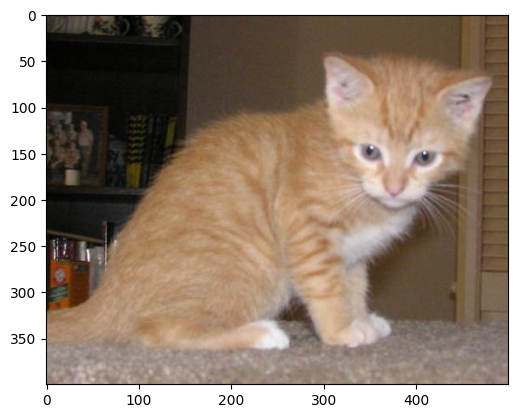

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img);

In [12]:
for fname in glob(f'{dog_dir}/*'):
  try:
    img = Image.open(fname)
  except:
    print(fname)

PetImages/Dog/11702.jpg


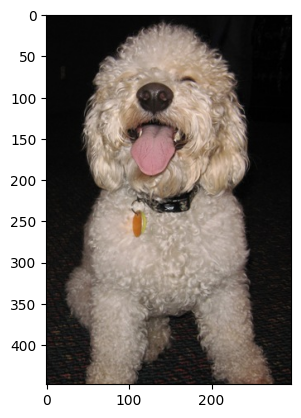

In [13]:
import matplotlib.pyplot as plt
plt.imshow(img);

- train data: 0.jpg ~ 7999.jpg (8,000개)
- valid data: 8000.jpg ~ 9999.jpg (2,000개)
- test data: 10000.jpg ~ 12499.jpg (2,500개)

In [14]:
# 오류난 데이터 삭제
!cp PetImages/Cat/9999.jpg PetImages/Cat/666.jpg
!cp PetImages/Dog/9999.jpg PetImages/Dog/11702.jpg

In [15]:
!mkdir  PetImages/test PetImages/valid
!mkdir  PetImages/test/cats PetImages/test/dogs
!mkdir  PetImages/valid/cats PetImages/valid/dogs

In [16]:
!mv  PetImages/Cat/8???.* PetImages/valid/cats
!mv  PetImages/Dog/8???.* PetImages/valid/dogs
!mv  PetImages/Cat/9???.* PetImages/valid/cats
!mv  PetImages/Dog/9???.* PetImages/valid/dogs

In [17]:
!mv  PetImages/Cat/1???.* PetImages/test/cats
!mv  PetImages/Dog/1???.* PetImages/test/dogs

In [18]:
!mkdir  PetImages/train
!mv  PetImages/Cat PetImages/train/cats
!mv  PetImages/Dog PetImages/train/dogs

In [19]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),   # 이미지를 150x150의 크기로 변환해주는 무언가가 필요함
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [21]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.path = 'best-cats-and-dogs.h5'
mc = ModelCheckpoint(model.path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

- 파일에서 이미지 데이터를 읽어서 학습시키는 방법

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

In [23]:
train_dir = 'PetImages/train'   # 8000 + 8000
test_dir = 'PetImages/test'     # 2500,+ 2500
valid_dir = 'PetImages/valid'   # 2000 + 2000

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 19000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


- 모델 학습

In [25]:
hist = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    steps_per_epoch=800,    # batch_size(20) x step_per_epoch(800) = 16000, 트레인 데이터가 16,000개
    validation_steps=200,     # batch_size(20) x step_per_epoch(200) = 4000, 검증 데이터가 4,000개
    callbacks=[mc, es]
    )

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.6576
Epoch 1: val_loss improved from inf to 0.54645, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 55s 52ms/step - loss: 0.6200 - accuracy: 0.6576 - val_loss: 0.5465 - val_accuracy: 0.7325
Epoch 2/100
799/800 [============================>.] - ETA: 0s - loss: 0.5163 - accuracy: 0.7482
Epoch 2: val_loss improved from 0.54645 to 0.47426, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 41s 52ms/step - loss: 0.5163 - accuracy: 0.7483 - val_loss: 0.4743 - val_accuracy: 0.7778
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.7915
Epoch 3: val_loss improved from 0.47426 to 0.44339, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 38s 48ms/step - loss: 0.4522 - accuracy: 0.7915 - val_loss: 0.4434 - val_accuracy: 0.7950
Epoch 4/100
799/800 [=======================

In [26]:
best_model = load_model(model.path)
best_model.evaluate(test_generator)

100/100 [==============================] - 4s 36ms/step - loss: 0.3950 - accuracy: 0.8210


[0.39503586292266846, 0.8209999799728394]

- 테스트 이미지 분류

In [27]:
from google.colab import files
up = files.upload()

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.jpg to cat3.jpg
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg


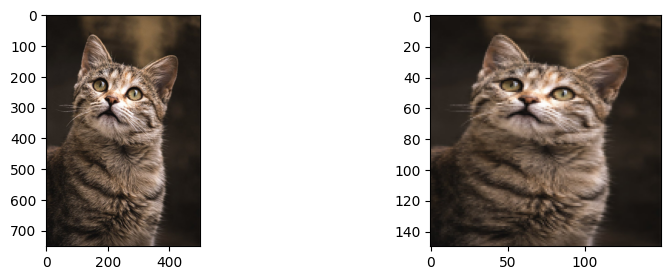

In [28]:
import cv2
img = cv2.imread('cat2.jpg')[:,:,::-1]
img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [31]:
best_model.predict(img2.reshape(-1, 150, 150, 3))  # -1 은 앞의 차원을 늘려서

1/1 [==============================] - 0s 18ms/step


array([[0.]], dtype=float32)

In [32]:
for fname in up.keys():
  img = cv2.imread(fname)[:,:,::-1]
  img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
  classes = best_model.predict(img2.reshape(-1,150,150,3), verbose=0)
  print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

1.0000 cat1.jpg is a dog
1.0000 cat2.jpg is a dog
1.0000 cat3.jpg is a dog
1.0000 dog1.jpg is a dog
1.0000 dog2.jpg is a dog
0.0000 dog3.jpg is a cat
